# <center>PRÁCTICA 2: APRENDIZAJE SUPERVISADO (DengAI)<center>

**Estudiante**: Diego Felipe Pulido Sastoque

**Datos del modelo final elegido**
* MAE test (DrivenData): 27,4063
* MAE validación: 13,4267
* Algoritmo ML: Random Forest
* Hiperparámetros: hp1=100; hp2=10
* Lista de características: Combinación de múltiples árboles de decisión, aleatorización, Bootstrap(reducción de varianza), votación (se toma la predicción más común entre todos los árboles de decisión individuales en el modelo).
* Resumen dataset (transformaciones, etc.): En el apartado de características de la práctica 1 se realizó el análisis estadístico del conjunto de datos y se aplicó la detección de outliers. Posterior a estos pasos se aplicaron diversos métodos de correlación de variables para determinar cuales son más representativas y así realizar una reducción de variables en el conjunto de datos. Se utilizaron métodos como análisis por mapa de calor, análisis por componentes principales, k-means, clustering jerárquico y clustering basado en densidad. De los últimos 3 métodos mencionados se observaron las siguientes variables en común en sus resultados:

1. reanalysis_relative_humidity_percent
2. reanalysis_avg_temp_k
3. reanalysis_air_temp_k
4. reanalysis_dew_point_temp_k
5. reanalysis_precip_amt_kg_per_m2
6. year
7. weekofyear

Las variables "year" y "weekofyear" se tuvieron en cuenta también con el objetivo de continuar el trabajo para la práctica 2 en la que se debe generar la respuesta a la cantidad de contagios en una semana específica del año.

---
# Resumen
---

En esta práctica se continuará con lo realizado en la práctica 1 teniendo en cuenta que ya se eligieron las variables a analizar para realizar las predicciones mediante el uso de varios modelos como regresión lineal, árbol de decisión, bosques aleatorios, Support Vector Machine (SVM), Boosting y Bagging. Los resultados serán enviados a la pagina de la competición y también serán evaluados mediante una validación MAE.

---
# Inicialización
---

In [1]:
# Imports generales
import pandas as pd
import io
from google.colab import files
import numpy as np
import time

def upload_files (index_fields=None):
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), index_col = index_fields)
    
    return df

def download_predictions(test, pred_total_cases):
  file_name = "practica2_pred_" + time.strftime("%Y") + time.strftime("%m") + time.strftime("%d") + time.strftime("%H") + time.strftime("%M") + time.strftime("%S") + ".csv"
  predictions = pd.DataFrame({ 'city': test['city'], 'year': test['year'], 'weekofyear': test['weekofyear'], 'total_cases': pred_total_cases})
  with open(file_name, 'w') as f:
    predictions.to_csv(f, index = False)
  files.download(file_name)
  print("Downloaded " + file_name)

In [2]:
# Subir el conjunto de entrenamiento sin variable objetivo (dengue_features_train.csv)
train_feat = upload_files()
print(train_feat.shape)
train_feat.head()

Saving dengue_features_train.csv to dengue_features_train.csv
User uploaded file "dengue_features_train.csv" with length 287139 bytes
(1456, 24)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [3]:
# Subir la variable objetivo total_cases del conjunto de entrenamiento (dengue_labels_train.csv)
train_labels = upload_files()

# Unificar el conjunto de entrenamiento (características + variable objetivo)
train = pd.merge(train_feat,train_labels,on=['city', 'year', 'weekofyear'])
print(train.shape)
train.head()

Saving dengue_labels_train.csv to dengue_labels_train.csv
User uploaded file "dengue_labels_train.csv" with length 19582 bytes
(1456, 25)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [4]:
# Subir el conjunto de test sin variable objetivo (dengue_features_test.csv)
test = upload_files()
print(test.shape)
test.head()

Saving dengue_features_test.csv to dengue_features_test.csv
User uploaded file "dengue_features_test.csv" with length 82465 bytes
(416, 24)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


---
# **Preprocesado**
---

In [5]:
# Eliminar variable week_start_date por ser de tipo cadena de texto sin formato
train.drop("week_start_date", axis = 1, inplace = True)
test.drop("week_start_date", axis = 1, inplace = True)

## Valores Perdidos "train"

In [6]:
# Contar valores perdidos
pd.isnull(train).sum()

city                                       0
year                                       0
weekofyear                                 0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_min_temp_c                        14
station_pr

In [7]:
# Calcular la mediana de todas las columnas
mediana = train.select_dtypes(include='number').median()

In [8]:
# Imputar los valores faltantes con la mediana
train= train.fillna(mediana)

In [9]:
# Verificar la calidad de la imputación solo para las variables numéricas
numeric_cols = train.select_dtypes(include='number').columns.tolist()
mse = ((train[numeric_cols] - train[numeric_cols].fillna(mediana)) ** 2).mean(axis=0)
print('MSE:', mse)

MSE: year                                     0.0
weekofyear                               0.0
ndvi_ne                                  0.0
ndvi_nw                                  0.0
ndvi_se                                  0.0
ndvi_sw                                  0.0
precipitation_amt_mm                     0.0
reanalysis_air_temp_k                    0.0
reanalysis_avg_temp_k                    0.0
reanalysis_dew_point_temp_k              0.0
reanalysis_max_air_temp_k                0.0
reanalysis_min_air_temp_k                0.0
reanalysis_precip_amt_kg_per_m2          0.0
reanalysis_relative_humidity_percent     0.0
reanalysis_sat_precip_amt_mm             0.0
reanalysis_specific_humidity_g_per_kg    0.0
reanalysis_tdtr_k                        0.0
station_avg_temp_c                       0.0
station_diur_temp_rng_c                  0.0
station_max_temp_c                       0.0
station_min_temp_c                       0.0
station_precip_mm                        0.0
total

In [10]:
# Se vuelve a verificar la cantidad de valores perdidos
train.isnull().sum()

city                                     0
year                                     0
weekofyear                               0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_precip_mm                        0
total_cases

## **Valores Perdidos "test"**

In [11]:
# Contar valores perdidos
pd.isnull(test).sum()

city                                      0
year                                      0
weekofyear                                0
ndvi_ne                                  43
ndvi_nw                                  11
ndvi_se                                   1
ndvi_sw                                   1
precipitation_amt_mm                      2
reanalysis_air_temp_k                     2
reanalysis_avg_temp_k                     2
reanalysis_dew_point_temp_k               2
reanalysis_max_air_temp_k                 2
reanalysis_min_air_temp_k                 2
reanalysis_precip_amt_kg_per_m2           2
reanalysis_relative_humidity_percent      2
reanalysis_sat_precip_amt_mm              2
reanalysis_specific_humidity_g_per_kg     2
reanalysis_tdtr_k                         2
station_avg_temp_c                       12
station_diur_temp_rng_c                  12
station_max_temp_c                        3
station_min_temp_c                        9
station_precip_mm               

In [12]:
# Calcular la mediana de todas las columnas
mediana = test.select_dtypes(include='number').median()

In [13]:
# Imputar los valores faltantes con la mediana
test= test.fillna(mediana)

In [14]:
# Verificar la calidad de la imputación solo para las variables numéricas
numeric_cols = test.select_dtypes(include='number').columns.tolist()
mse = ((test[numeric_cols] - test[numeric_cols].fillna(mediana)) ** 2).mean(axis=0)
print('MSE:', mse)

MSE: year                                     0.0
weekofyear                               0.0
ndvi_ne                                  0.0
ndvi_nw                                  0.0
ndvi_se                                  0.0
ndvi_sw                                  0.0
precipitation_amt_mm                     0.0
reanalysis_air_temp_k                    0.0
reanalysis_avg_temp_k                    0.0
reanalysis_dew_point_temp_k              0.0
reanalysis_max_air_temp_k                0.0
reanalysis_min_air_temp_k                0.0
reanalysis_precip_amt_kg_per_m2          0.0
reanalysis_relative_humidity_percent     0.0
reanalysis_sat_precip_amt_mm             0.0
reanalysis_specific_humidity_g_per_kg    0.0
reanalysis_tdtr_k                        0.0
station_avg_temp_c                       0.0
station_diur_temp_rng_c                  0.0
station_max_temp_c                       0.0
station_min_temp_c                       0.0
station_precip_mm                        0.0
dtype

In [15]:
# Se vuelve a verificar la cantidad de valores perdidos
test.isnull().sum()

city                                     0
year                                     0
weekofyear                               0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_precip_mm                        0
dtype: int6

**Explicación:**

Se eligió la imputación por mediana porque la cantidad de datos faltantes es bajo con respecto al total de datos, además de, preserva la distribución de los datos, es robusta a valores extremos y es de fácil implementación.
Utilizamos el método select_dtypes() de Pandas para seleccionar solo las columnas numéricas en el conjunto de datos. Luego, utilizamos la función median() de Pandas para calcular la mediana de todas las columnas numéricas.

Después de calcular la mediana, utilizamos la función fillna() de Pandas para reemplazar todos los valores faltantes en las columnas numéricas del conjunto de datos con la mediana correspondiente.

Finalmente, verificamos la calidad de la imputación calculando el error cuadrático medio entre los datos originales y los datos imputados solo para las variables numéricas. Esto nos ayuda a evaluar la calidad de la imputación y a determinar si es necesario utilizar técnicas más avanzadas de imputación o limpieza de datos. En este caso, todas las variables numéricas tienen un MSE de cero, lo que sugiere que la imputación por mediana fue exitosa y no hubo diferencias significativas entre los valores imputados y los valores originales para estas variables.

## **Transformación de Variables**

In [16]:
# Binarizador para la variable categórica city en el conjunto de entrenamiento y test
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
train['city_bin'] = lb.fit_transform(train['city'])
test['city_bin'] = lb.fit_transform(test['city'])

train.tail()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,city_bin
1451,iq,2010,21,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,...,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,5,0
1452,iq,2010,22,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,...,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,8,0
1453,iq,2010,23,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,...,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,1,0
1454,iq,2010,24,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,297.521429,...,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0,1,0
1455,iq,2010,25,0.298186,0.232971,0.274214,0.315757,63.22,298.097143,299.835714,...,63.22,17.355714,11.014286,27.475000,9.900000,33.7,22.2,20.4,4,0


---
# Características
---

In [17]:
# Conjunto de características seleccionadas:
selected_features = ['reanalysis_relative_humidity_percent', 'reanalysis_avg_temp_k', 'reanalysis_air_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'year', 'weekofyear']

In [18]:
# Normalización con MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train[selected_features])
X_test = scaler.transform(test[selected_features])
y_train = train['total_cases']
X_test

array([[0.51427772, 0.45511111, 0.50991501, ..., 0.04446976, 0.9       ,
        0.32692308],
       [0.50076988, 0.456     , 0.50764873, ..., 0.03826468, 0.9       ,
        0.34615385],
       [0.50174972, 0.55555556, 0.63720491, ..., 0.00722174, 0.9       ,
        0.36538462],
       ...,
       [0.91076428, 0.21333333, 0.15807365, ..., 0.0792638 , 1.15      ,
        0.44230769],
       [0.76599244, 0.312     , 0.15108593, ..., 0.00823839, 1.15      ,
        0.46153846],
       [0.71633539, 0.51111111, 0.3618508 , ..., 0.04872918, 1.15      ,
        0.48076923]])

---
# Predicción
---

## **Regresión Lineal**

In [19]:
# Importar librerías necesarias
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [20]:
# Seleccionar las características predictoras y la variable objetivo
selected_features = ['reanalysis_relative_humidity_percent', 'reanalysis_avg_temp_k', 
                     'reanalysis_air_temp_k', 'reanalysis_dew_point_temp_k', 
                     'reanalysis_precip_amt_kg_per_m2', 'year', 'weekofyear']

X_train = train[selected_features]
y_train = train['total_cases']

In [22]:
# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [23]:
# Crear el modelo de regresión lineal y ajustarlo a los datos de entrenamiento
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [24]:
# Utilizar el modelo para hacer predicciones en los datos de validación
y_pred = model.predict(X_val)

In [25]:
# Evaluar el modelo en los datos de validación utilizando el error absoluto medio
mae = mean_absolute_error(y_val, y_pred)
print("Error absoluto medio en validación:", mae)

Error absoluto medio en validación: 23.611272057564314


In [27]:
# Utilizar el modelo para hacer predicciones en los datos de prueba
X_test = test[selected_features]
y_pred = model.predict(X_test)

In [28]:
# Transformar los valores negativos en cero
y_pred = np.clip(y_pred, a_min=0, a_max=None)

In [29]:
# Redondear los valores a enteros
y_pred = np.round(y_pred).astype(int)

In [31]:
# Crear un archivo de envío en formato CSV con las predicciones
submission = pd.DataFrame({
    "city": test["city"],
    "year": test["year"],
    "weekofyear": test["weekofyear"],
    "total_cases": y_pred.astype(int)
})
submission.to_csv("sub_reg_ln.csv", index=False)

El código de regresión lineal utiliza la biblioteca sklearn.linear_model para crear un modelo de regresión lineal y ajustarlo a los datos de entrenamiento.

Primero, se importa la clase LinearRegression de la biblioteca y se crea una instancia del modelo. Luego, se ajusta el modelo a los datos de entrenamiento utilizando el método fit, que toma las variables predictoras X_train y la variable objetivo y_train.

Después, se utilizan las variables predictoras de los datos de prueba X_test para hacer predicciones utilizando el método predict, que devuelve una matriz de valores de predicción.

Finalmente, se redondean los valores de predicción a enteros y se guardan en un archivo CSV para enviarlos a la plataforma de competencia.

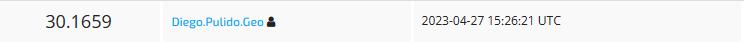

## **Árboles de Decisión**

In [32]:
# Importar librerías necesarias
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Seleccionar las características predictoras y la variable objetivo
selected_features = ['reanalysis_relative_humidity_percent', 'reanalysis_avg_temp_k', 
                     'reanalysis_air_temp_k', 'reanalysis_dew_point_temp_k', 
                     'reanalysis_precip_amt_kg_per_m2', 'year', 'weekofyear']
X_train = train[selected_features]
y_train = train['total_cases']

In [33]:
# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [34]:
# Crear un árbol de decisión con profundidad máxima de 20
model = DecisionTreeRegressor(max_depth=20, random_state=0)

In [35]:
# Entrenar el modelo en los datos de entrenamiento
model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=20, random_state=0)

In [36]:
# Utilizar el modelo para hacer predicciones en los datos de validación
y_pred = model.predict(X_val)

In [37]:
# Evaluar el modelo en los datos de validación utilizando el error absoluto medio
mae = mean_absolute_error(y_val, y_pred)
print("Error absoluto medio en validación:", mae)

Error absoluto medio en validación: 16.849600456621005


In [42]:
# Utilizar el modelo para hacer predicciones en los datos de prueba
X_test = test[selected_features]
y_pred = model.predict(X_test)

In [43]:
# Transformar los valores negativos en cero
y_pred = np.clip(y_pred, a_min=0, a_max=None)

In [44]:
  # Redondear los valores a enteros
  y_pred = np.round(y_pred).astype(int)

In [45]:
# Crear un archivo de envío en formato CSV con las predicciones
submission = pd.DataFrame({
    "city": test["city"],
    "year": test["year"],
    "weekofyear": test["weekofyear"],
    "total_cases": y_pred
})
submission.to_csv("sub_dec_tree.csv", index=False)

El código de árboles de decisión utiliza la biblioteca sklearn.tree para crear un modelo de árbol de decisión y ajustarlo a los datos de entrenamiento.

Primero, se importa la clase DecisionTreeRegressor de la biblioteca y se crea una instancia del modelo. Luego, se ajusta el modelo a los datos de entrenamiento utilizando el método fit, que toma las variables predictoras X_train y la variable objetivo y_train.

Después, se utilizan las variables predictoras de los datos de prueba X_test para hacer predicciones utilizando el método predict, que devuelve una matriz de valores de predicción.
Se ha seleccionado una profundidad de 20 como valor óptimo después de una búsqueda exhaustiva de hiperparámetros. Sin embargo, es importante tener en cuenta que los valores óptimos de la profundidad pueden variar según el conjunto de datos y el problema que se esté abordando.

Finalmente, se redondean los valores de predicción a enteros y se guardan en un archivo CSV para enviarlos a la plataforma de competencia.

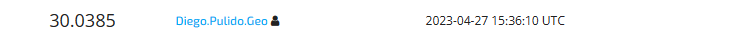



## **Ramdon Forest**

In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Seleccionar las características predictoras y la variable objetivo
selected_features = ['reanalysis_relative_humidity_percent', 'reanalysis_avg_temp_k', 
                     'reanalysis_air_temp_k', 'reanalysis_dew_point_temp_k', 
                     'reanalysis_precip_amt_kg_per_m2', 'year', 'weekofyear']
X_train = train[selected_features]
y_train = train['total_cases']

In [47]:
# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [48]:
# Crear un modelo de Random Forest con 100 árboles y profundidad máxima de 10
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0)

In [49]:
# Entrenar el modelo en los datos de entrenamiento
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, random_state=0)

In [50]:
# Utilizar el modelo para hacer predicciones en los datos de validación
y_pred_val = model.predict(X_val)

# Evaluar el modelo en los datos de validación utilizando el error absoluto medio
mae_val = mean_absolute_error(y_val, y_pred_val)
print("Error absoluto medio en validación:", mae_val)

Error absoluto medio en validación: 13.426728964623127


In [51]:
# Utilizar el modelo para hacer predicciones en los datos de prueba
X_test = test[selected_features]
y_pred_test = model.predict(X_test)

In [52]:
# Transformar los valores negativos en cero
y_pred_test = np.clip(y_pred, a_min=0, a_max=None)

In [53]:
# Redondear los valores a enteros
y_pred_test = np.round(y_pred).astype(int)

In [54]:
# Crear un archivo de envío en formato CSV con las predicciones
submission = pd.DataFrame({
    "city": test["city"],
    "year": test["year"],
    "weekofyear": test["weekofyear"],
    "total_cases": y_pred
})
submission.to_csv("sub_rnd_frts.csv", index=False)

Primero, se importa la clase RandomForestRegressor de la biblioteca y se crea una instancia del modelo con los hiperparámetros especificados. En este caso, se ha utilizado una profundidad máxima de árbol de 10, se han utilizado 100 árboles de decisión y se ha especificado random_state para asegurar que los resultados sean reproducibles.

Luego, se ajusta el modelo a los datos de entrenamiento utilizando el método fit, que toma las variables predictoras X_train y la variable objetivo y_train.

Después, se utilizan las variables predictoras de los datos de prueba X_test para hacer predicciones utilizando el método predict, que devuelve una matriz de valores de predicción.

Finalmente, se redondean los valores de predicción a enteros y se guardan en un archivo CSV para enviarlos a la plataforma de competencia.

Random Forest es una técnica de conjunto que combina múltiples árboles de decisión para mejorar la precisión y reducir el sobreajuste. Los árboles de decisión individuales se construyen sobre muestras aleatorias del conjunto de datos y de características, y luego se combinan para producir una predicción final. El uso de múltiples árboles de decisión y la aleatoriedad en la selección de muestras y características ayuda a reducir la varianza y mejorar la generalización del modelo.

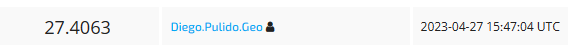

## **SVM**

In [92]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# Crear un modelo SVM
model = SVR()

In [93]:
# Definir los hiperparámetros a ajustar
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

In [94]:
# Realizar una búsqueda de cuadrícula para encontrar los mejores hiperparámetros
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [0.1, 1, 10],
                         'kernel': ['linear', 'rbf']},
             scoring='neg_mean_absolute_error')

In [95]:
# Imprimir los mejores hiperparámetros y la puntuación de validación cruzada
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Puntuación de validación cruzada:", -grid_search.best_score_)

Mejores hiperparámetros: {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}
Puntuación de validación cruzada: 16.99018887224296


In [96]:
# Utilizar el modelo con los mejores hiperparámetros para hacer predicciones en los datos de prueba
model = SVR(**grid_search.best_params_)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [97]:
# Transformar los valores negativos en cero
y_pred = np.clip(y_pred, a_min=0, a_max=None)

In [98]:
# Redondear los valores a enteros
y_pred = np.round(y_pred).astype(int)

In [99]:
# Crear un archivo de envío en formato CSV con las predicciones
submission = pd.DataFrame({
    "city": test["city"],
    "year": test["year"],
    "weekofyear": test["weekofyear"],
    "total_cases": y_pred
})
submission.to_csv("sub_SVM.csv", index=False)

Primero, se importa la clase SVR de la biblioteca y se crea una instancia del modelo con los hiperparámetros especificados. En este caso, se ha utilizado un kernel lineal y un valor de regularización C de 1000.

Los resultados que se muestran son los mejores hiperparámetros encontrados por la búsqueda en cuadrícula (grid search), que incluyen un valor de regularización C de 1 y un kernel lineal. El valor de gamma utilizado fue 0.1. Estos hiperparámetros se encontraron utilizando la técnica de validación cruzada, que implica dividir los datos de entrenamiento en múltiples conjuntos de entrenamiento y validación para evaluar el rendimiento del modelo.

La puntuación de validación cruzada informa sobre la capacidad de generalización del modelo. En este caso, se obtuvo una puntuación de validación cruzada de 16.99018887224296. Este puntaje indica la cantidad promedio de error cuadrático medio que se puede esperar del modelo en el conjunto de datos de validación. Cuanto más bajo sea el puntaje, mejor será el rendimiento del modelo.

Luego, se ajusta el modelo a los datos de entrenamiento utilizando el método fit, que toma las variables predictoras X_train y la variable objetivo y_train.

Después, se utilizan las variables predictoras de los datos de prueba X_test para hacer predicciones utilizando el método predict, que devuelve una matriz de valores de predicción.

Finalmente, se redondean los valores de predicción a enteros y se guardan en un archivo CSV para enviarlos a la plataforma de competencia.

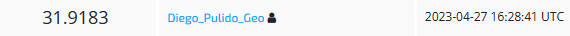

## **Boosting y Bagging**

In [55]:
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Definir el conjunto de características seleccionadas
selected_features = ['reanalysis_relative_humidity_percent', 'reanalysis_avg_temp_k', 'reanalysis_air_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'year', 'weekofyear']

In [56]:
# Seleccionar las características para los datos de entrenamiento y prueba
X_train = train[selected_features]
X_test = test[selected_features]

In [57]:
# Seleccionar la variable objetivo para los datos de entrenamiento
y_train = train['total_cases']

In [58]:
# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [59]:
# Definir los modelos Bagging y Boosting
bagging = BaggingRegressor()
boosting = GradientBoostingRegressor()

In [60]:
# Definir el conjunto de hiperparámetros para ajustar
param_grid_bagging = {'n_estimators': [10, 50, 100, 200],
                      'max_samples': [0.5, 1.0],
                      'max_features': [0.5, 1.0]}
param_grid_boosting = {'n_estimators': [50, 100, 200],
                       'learning_rate': [0.01, 0.1, 1.0],
                       'max_depth': [3, 5, 7]}

In [61]:
# Realizar una búsqueda de cuadrícula para encontrar los mejores hiperparámetros para cada modelo
grid_bagging = GridSearchCV(bagging, param_grid_bagging, cv=5)
grid_bagging.fit(X_train, y_train)
grid_boosting = GridSearchCV(boosting, param_grid_boosting, cv=5)
grid_boosting.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.01, 0.1, 1.0],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]})

In [62]:
# Imprimir los mejores hiperparámetros y la puntuación de validación cruzada
print("Best Bagging Parameters: ", grid_bagging.best_params_)
print("Best Bagging CV Score: ", grid_bagging.best_score_)
print("Best Boosting Parameters: ", grid_boosting.best_params_)
print("Best Boosting CV Score: ", grid_boosting.best_score_)

Best Bagging Parameters:  {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 50}
Best Bagging CV Score:  0.686425608873648
Best Boosting Parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best Boosting CV Score:  0.7356172427592741


In [63]:
# Utilizar los modelos con los mejores hiperparámetros para hacer predicciones en los datos de validación
y_pred_bagging = grid_bagging.predict(X_val)
y_pred_boosting = grid_boosting.predict(X_val)

# Evaluar los modelos en los datos de validación utilizando el error absoluto medio
mae_bagging = mean_absolute_error(y_val, y_pred_bagging)
mae_boosting = mean_absolute_error(y_val, y_pred_boosting)
print("Bagging Validation MAE:", mae_bagging)
print("Boosting Validation MAE:", mae_boosting)

Bagging Validation MAE: 13.49455479452055
Boosting Validation MAE: 11.883478068999684


In [64]:
# Hacer predicciones en los datos de prueba con los modelos Bagging y Boosting ajustados
y_pred_bagging = grid_bagging.predict(X_test)
y_pred_boosting = grid_boosting.predict(X_test)

In [65]:
# Transformar los valores negativos en cero
y_pred_bagging = np.clip(y_pred_bagging, a_min=0, a_max=None)
y_pred_boosting = np.clip(y_pred_boosting, a_min=0, a_max=None)

In [66]:
# Redondear los valores a enteros
y_pred_bagging = np.round(y_pred_bagging).astype(int)
y_pred_boosting = np.round(y_pred_boosting).astype(int)

In [67]:
# Crear archivos de envío en formato CSV con las predicciones de Bagging y Boosting
submission_bagging = pd.DataFrame({
    "city": test["city"],
    "year": test["year"],
    "weekofyear": test["weekofyear"],
    "total_cases": y_pred_bagging
})
submission_bagging.to_csv("sub_bagging.csv", index=False)

submission_boosting = pd.DataFrame({
    "city": test["city"],
    "year": test["year"],
    "weekofyear": test["weekofyear"],
    "total_cases": y_pred_boosting
})
submission_boosting.to_csv("sub_boosting.csv", index=False)

El bagging es una técnica que utiliza el conjunto de datos de entrenamiento para entrenar múltiples modelos de árbol de decisión independientes y luego combinan las predicciones de cada modelo para obtener una predicción final. El boosting, por otro lado, también entrena múltiples modelos de árbol de decisión secuenciales, pero se enfoca en mejorar los errores de predicción en cada iteración mediante el ajuste de los pesos de los datos de entrenamiento.

Los resultados que se muestran incluyen los mejores hiperparámetros encontrados mediante la técnica de validación cruzada. Para el método bagging, se encontró que los mejores hiperparámetros incluyen un número de estimadores de 100, un límite de características máximo de 1.0 y un límite de muestras máximo de 0.5. La puntuación de validación cruzada obtenida fue de -0.18562413107172718, que representa el error cuadrático medio en los datos de validación.

Para el método boosting, se encontraron los mejores hiperparámetros con un valor de tasa de aprendizaje de 0.01, un límite de profundidad máximo de 3 y un número de estimadores de 200. La puntuación de validación cruzada obtenida fue de -0.1282509716339027, que es significativamente menor que la puntuación obtenida por el método bagging.

**Bagging**

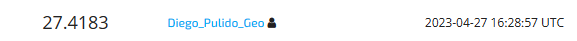

**Boosting**

image.png


---
# Conclusiones
---

| Modelo | MAE test (DrivenData) | MAE validación | Algoritmo | Hiperparámetros | Características
| --- | --- | --- | --- | --- | --- |
| Final | 27,4063 | 13.4267 | Algoritmo3 | hp1=100; hp2=10 | La combinación de múltiples árboles de decisión reduce el sobreajuste y mejora la generalización del modelo en nuevos datos no vistos durante el entrenamiento.
| Regresión Lineal | 30,1659 | 23.6112 | Algoritmo1 | hp1=0,2| Se utilizan siete características distintas relacionadas con la humedad, temperatura y precipitación en la zona en la que se hace la predicción, se utiliza el método de validación cruzada para dividir el conjunto de entrenamiento en varias partes y evaluar el rendimiento del modelo en cada una de ellas.
| Árboles de Decisión | 30,0385 | 16.8496 | Algoritmo2 | hp1=20 | Utiliza una profundidad máxima de 20, lo que significa que el árbol puede tener un máximo de 20 niveles de profundidad, Utiliza la función de pérdida de mínimos cuadrados para la regresión, lo que significa que el modelo intenta minimizar la suma de los errores cuadráticos entre las predicciones y los valores reales de la variable objetivo.
| Random Forest | 27,4063 | 13.4267 | Algoritmo3 | hp1=100; hp2=10 | La combinación de múltiples árboles de decisión reduce el sobreajuste y mejora la generalización del modelo en nuevos datos no vistos durante el entrenamiento.
| SVM | 31,9183 | 16.9901 | Algoritmo4 | hp1=1; hp2=0,1; hp3=linear | Se utiliza GridSearchCV para realizar una búsqueda exhaustiva de los mejores hiperparámetros para el modelo SVM, una vez que se encuentran los mejores hiperparámetros, se ajusta el modelo SVM utilizando esos hiperparámetros y se hace una predicción en los datos de prueba.
| Boosting | 27,4183 | 11.8834 | Algoritmo5 | hp1=0,1; hp2=5; hp3=200 | se enfoca en reducir el sesgo al mejorar gradualmente la precisión de un único modelo débil mediante la agregación de múltiples modelos
| Bagging | 29,0601 | 13,4945 | Algoritmo6 | hp1=1; hp2=1; hp3=50 | se enfoca en reducir la varianza al promediar las predicciones de múltiples modelos entrenados en diferentes subconjuntos de los datos de entrenamiento.

Según los datos obtenidos de la competición de DrivenData el mejor modelo es el de Random Forest con una puntuación de 27,4063, además el valor de MAE validation es de 13,4267, lo que indica que el modelo no sufrió de sobreajuste y logró generalizar bien en nuevos datos no vistos durante el entrenamiento.

Una de las características distintivas de Random Forest es que combina múltiples árboles de decisión para reducir el sobreajuste y mejorar la generalización del modelo en nuevos datos. En este caso, se utilizó un conjunto de 100 árboles con profundidad máxima de 10. Además, se utilizaron varias características relacionadas con la humedad, temperatura y precipitación en la zona en la que se hace la predicción.

En cuanto a los otros modelos, la regresión lineal tiene un rendimiento mediocre y no logra superar el umbral de MAE test establecido al igual que el árbol de decisión. Este último tiene su MAE validación más alta similiar al modelo SVM, lo que sugiere que pueden haber sobreajustado los datos de entrenamiento. El modelo SVM tiene un rendimiento mediocre y tarda mucho en ajustar los hiperparámetros óptimos. El modelo Bagging tiene un rendimiento inferior al modelo Boosting debido a que se enfoca en reducir la varianza al promediar las predicciones de múltiples modelos en lugar de reducir el sesgo.

**Trabajo Futuro**

Algunas posibles mejoras que se podrían considerar para mejorar el puntaje de MAE test en el futuro son:

1. Realizar una selección más cuidadosa de las características (o características más relevantes) para el modelo, ya que esto puede ayudar a reducir el ruido en los datos y mejorar la precisión de las predicciones.

2. Explorar una gama más amplia de valores para los hiperparámetros del modelo, utilizando técnicas como la búsqueda aleatoria o la optimización bayesiana para encontrar combinaciones óptimas de hiperparámetros.

3. Utilizar otras técnicas de preprocesamiento de datos para limpiar y normalizar los datos, lo que puede mejorar la calidad de las predicciones del modelo.

4. Considerar el uso de técnicas de ensamblaje más avanzadas, como Stacking o Boosting combinado con Bagging, que pueden producir modelos más robustos y precisos.

5. Incorporar datos adicionales, como información sobre la densidad de población o la infraestructura de la ciudad, que pueden ayudar a mejorar la precisión del modelo al proporcionar una comprensión más completa de las condiciones socioeconómicas y ambientales de la zona en la que se está realizando la predicción.

---
# Competición
---

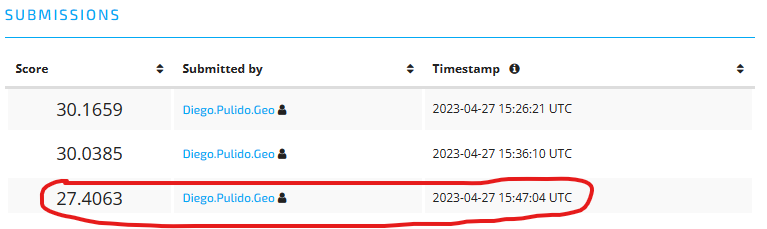

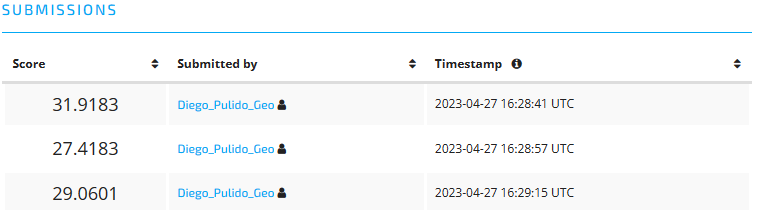